In [2]:
import pandas as pd
import numpy as np
import os
import shutil
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
import keras.backend as K
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM, Activation
from keras.utils import to_categorical

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

print("Libraries Imported")

Libraries Imported


In [3]:
# --- 1. RAVDESS ---
ravdess_directory_list = os.listdir('/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/')
file_emotion, file_path = [], []
for dir in ravdess_directory_list:
    actor = os.listdir('/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/' + dir)
    for file in actor:
        part = file.split('.')[0].split('-')
        file_emotion.append(int(part[2]))
        file_path.append('/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/' + dir + '/' + file)
ravdess_df = pd.DataFrame(file_emotion, columns=['Emotions'])
ravdess_df['Path'] = file_path
ravdess_df.Emotions.replace({1:'Neutral', 2:'Neutral', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust', 8:'Surprise'}, inplace=True)

# --- 2. TESS ---
tess_directory_list = os.listdir('/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/')
file_emotion, file_path = [], []
for dir in tess_directory_list:
    directories = os.listdir('/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/' + dir)
    for file in directories:
        part = file.split('.')[0].split('_')[2]
        if part=='ps': file_emotion.append('Surprise')
        else: file_emotion.append(part.capitalize())
        file_path.append('/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/' + dir + '/' + file)
tess_df = pd.DataFrame(file_emotion, columns=['Emotions'])
tess_df['Path'] = file_path

# --- 3. SAVEE ---
savee_directory_list = os.listdir('/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/')
file_emotion, file_path = [], []
for file in savee_directory_list:
    file_path.append('/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/' + file)
    part = file.split('_')[1][:-6]
    if part=='a': file_emotion.append('Angry')
    elif part=='d': file_emotion.append('Disgust')
    elif part=='f': file_emotion.append('Fear')
    elif part=='h': file_emotion.append('Happy')
    elif part=='n': file_emotion.append('Neutral')
    elif part=='sa': file_emotion.append('Sad')
    else: file_emotion.append('Surprise')
savee_df = pd.DataFrame(file_emotion, columns=['Emotions'])
savee_df['Path'] = file_path

# --- MERGE & CLEAN ---
data_path = pd.concat([ravdess_df, tess_df, savee_df], axis = 0)
data_path = data_path[data_path.Emotions != 'Unknown']
data_path.reset_index(drop=True, inplace=True)

# --- DOWNSAMPLING NEUTRAL (BALANCING) ---
print("Distribution BEFORE Balancing:")
print(data_path['Emotions'].value_counts())

neutral_df = data_path[data_path['Emotions'] == 'Neutral']
other_df = data_path[data_path['Emotions'] != 'Neutral']

# Calculate target count (average of other classes to be fair)
target_count = int(other_df['Emotions'].value_counts().mean())
print(f"\nTarget count for Neutral: {target_count}")

# Downsample
if len(neutral_df) > target_count:
    neutral_downsampled = neutral_df.sample(n=target_count, random_state=42)
    data_path = pd.concat([neutral_downsampled, other_df], axis=0)
    data_path = data_path.sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle

print("\nDistribution AFTER Balancing:")
print(data_path['Emotions'].value_counts())

Distribution BEFORE Balancing:
Emotions
Neutral     808
Surprise    652
Disgust     652
Fear        652
Sad         652
Happy       652
Angry       652
Name: count, dtype: int64

Target count for Neutral: 652

Distribution AFTER Balancing:
Emotions
Happy       652
Neutral     652
Disgust     652
Fear        652
Angry       652
Surprise    652
Sad         652
Name: count, dtype: int64


In [4]:
# --- Augmentation Functions ---
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

# --- Feature Extraction ---
def extract_features(data, sample_rate):
    result = np.array([])
    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) 
    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) 
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) 
    # RMS
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) 
    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) 
    return result

# --- Pipelines ---
def get_features_train(path):
    # Training: Original + Noise + Stretch/Pitch
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # 1. Original
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # 2. Noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) 
    
    # 3. Stretch & Pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) 
    
    return result

def get_features_test(path):
    # Validation/Test: Original Only
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    res1 = extract_features(data, sample_rate)
    result = np.array([res1]) 
    return result

In [5]:
# 1. Split DataFrame FIRST (Stratified)
# Train: 80%, Temp: 20%
train_df, temp_df = train_test_split(data_path, test_size=0.2, random_state=42, stratify=data_path['Emotions'])
# Temp -> Val (10%) + Test (10%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Emotions'])

print(f"Train Files: {len(train_df)} | Val Files: {len(val_df)} | Test Files: {len(test_df)}")

le = LabelEncoder()
le.fit(data_path['Emotions'])
print(f"Label Mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

def process_and_save_files(df, split_name):
    """
    Copies .wav files to /kaggle/working/{split_name}, 
    renames them, and saves a CSV with path and label_id.
    """
    base_dir = '/kaggle/working'
    target_dir = os.path.join(base_dir, split_name)
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    csv_data = []
    
    print(f"Saving {split_name} files...")
    for idx, (src_path, emotion) in enumerate(zip(df.Path, df.Emotions)):
        # Rename file: train_0.wav
        new_filename = f"{split_name}_{idx}.wav"
        dst_path = os.path.join(target_dir, new_filename)

        try:
            shutil.copyfile(src_path, dst_path)
            label_id = le.transform([emotion])[0]
            csv_data.append({
                'file_path': f"{split_name}/{new_filename}",
                'label_id': label_id
            })
        except Exception as e:
            print(f"Error copying {src_path}: {e}")

    # Save CSV
    csv_df = pd.DataFrame(csv_data)
    csv_filename = f"{split_name}_final.csv"
    csv_df.to_csv(csv_filename, index=False)
    print(f"Saved {csv_filename} with {len(csv_df)} rows.")

# Execute for all sets
process_and_save_files(train_df, 'train')
process_and_save_files(val_df, 'val')
process_and_save_files(test_df, 'test')

print("-" * 30)

X_train, Y_train = [], []
X_val, Y_val = [], []
X_test, Y_test = [], []

# 2. Process Training Set (WITH Augmentation)
print("Processing Training Set...")
for path, emotion in zip(train_df.Path, train_df.Emotions):
    try:
        features = get_features_train(path)
        for ele in features:
            X_train.append(ele)
            Y_train.append(emotion)
    except: pass

# 3. Process Validation & Test Set (Original Only)
print("Processing Validation Set...")
for path, emotion in zip(val_df.Path, val_df.Emotions):
    try:
        features = get_features_test(path)
        for ele in features:
            X_val.append(ele)
            Y_val.append(emotion)
    except: pass

print("Processing Test Set...")
for path, emotion in zip(test_df.Path, test_df.Emotions):
    try:
        features = get_features_test(path)
        for ele in features:
            X_test.append(ele)
            Y_test.append(emotion)
    except: pass

print(f"\nAugmented Train Samples: {len(X_train)}")

Train Files: 3651 | Val Files: 456 | Test Files: 457
Label Mapping: {'Angry': np.int64(0), 'Disgust': np.int64(1), 'Fear': np.int64(2), 'Happy': np.int64(3), 'Neutral': np.int64(4), 'Sad': np.int64(5), 'Surprise': np.int64(6)}
Saving train files...
Saved train_final.csv with 3651 rows.
Saving val files...
Saved val_final.csv with 456 rows.
Saving test files...
Saved test_final.csv with 457 rows.
------------------------------
Processing Training Set...
Processing Validation Set...
Processing Test Set...

Augmented Train Samples: 10953


In [6]:
# 1. Encode Labels
encoder = OneHotEncoder()
# Fit on original labels to ensure consistency
all_emotions = np.array(data_path['Emotions']).reshape(-1, 1)
encoder.fit(all_emotions)

y_train_encoded = encoder.transform(np.array(Y_train).reshape(-1, 1)).toarray()
y_val_encoded = encoder.transform(np.array(Y_val).reshape(-1, 1)).toarray()
y_test_encoded = encoder.transform(np.array(Y_test).reshape(-1, 1)).toarray()

# 2. Scale Features
scaler = StandardScaler()
# FIT only on Training Data
x_train_scaled = scaler.fit_transform(X_train)
# TRANSFORM Val/Test
x_val_scaled = scaler.transform(X_val)
x_test_scaled = scaler.transform(X_test)

# 3. Reshape for CNN
x_train_cnn = np.expand_dims(x_train_scaled, axis=2)
x_val_cnn = np.expand_dims(x_val_scaled, axis=2)
x_test_cnn = np.expand_dims(x_test_scaled, axis=2)

# --- STATISTICS ---
print("\n--- DATA STATISTICS ---")
# Helper to decode and count
def get_counts(encoded_y):
    decoded = encoder.inverse_transform(encoded_y).ravel()
    return pd.Series(decoded).value_counts().sort_index()

stats_df = pd.DataFrame({
    'Train (Augmented)': get_counts(y_train_encoded),
    'Val (Original)': get_counts(y_val_encoded),
    'Test (Original)': get_counts(y_test_encoded)
})
stats_df['Total'] = stats_df.sum(axis=1)
print(stats_df)
print("\n" + "="*40 + "\n")


--- DATA STATISTICS ---
          Train (Augmented)  Val (Original)  Test (Original)  Total
Angry                  1566              65               65   1696
Disgust                1566              65               65   1696
Fear                   1566              65               65   1696
Happy                  1563              66               65   1694
Neutral                1563              65               66   1694
Sad                    1566              65               65   1696
Surprise               1563              65               66   1694




In [13]:
import tensorflow as tf

def f1_metric(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    #True Positives
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    
    #epsilon (avoid div by 0)
    epsilon = 1e-7
    precision = true_positives / (predicted_positives + epsilon)
    recall = true_positives / (possible_positives + epsilon)
    
    # Cal F1
    f1_val = 2 * (precision * recall) / (precision + recall + epsilon)
    return f1_val

In [14]:
num_classes = y_train_encoded.shape[1]

model = Sequential()

# CNN Layers
model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train_cnn.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# LSTM Layers
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(128))
model.add(Dropout(0.3))

# Dense Layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_metric])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 162, 1024)      │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 81, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 81, 1024)       │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 81, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 81, 512)        │     2,621,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 41, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 41, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 41, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 41, 256)        │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 21, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 21, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 21, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 21, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 21, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,778,247 (14.41 MB)

 Trainable params: 3,774,663 (14.40 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [15]:
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=1, patience=2, min_lr=0.0000001)
checkpoint = ModelCheckpoint("best_model_clstm1.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True)

history = model.fit(x_train_cnn, y_train_encoded, 
                    batch_size=64, 
                    epochs=50, 
                    validation_data=(x_val_cnn, y_val_encoded), 
                    callbacks=[rlrp, checkpoint, early_stop])

Epoch 1/50


I0000 00:00:1766995369.919273     177 cuda_dnn.cc:529] Loaded cuDNN version 91002


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2868 - f1_metric: 0.0519 - loss: 1.7220
Epoch 1: val_accuracy improved from -inf to 0.22588, saving model to best_model_clstm1.keras
172/172 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.2874 - f1_metric: 0.0527 - loss: 1.7210 - val_accuracy: 0.2259 - val_f1_metric: 0.1947 - val_loss: 2.7529 - learning_rate: 0.0010
Epoch 2/50
171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5685 - f1_metric: 0.5374 - loss: 1.1451
Epoch 2: val_accuracy did not improve from 0.22588
172/172 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.5690 - f1_metric: 0.5380 - loss: 1.1441 - val_accuracy: 0.1425 - val_f1_metric: 0.1416 - val_loss: 4.7091 - learning_rate: 0.0010
Epoch 3/50
171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6308 - f1_metric: 0.6227 - loss: 0.9974
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.

Epoch 3: val_accuracy improved from 0.22588 to 0.22807, saving model to best_model_clstm1.keras


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8544 - f1_metric: 0.8535 - loss: 0.3964
Accuracy on Test Data:  85.77680587768555 %


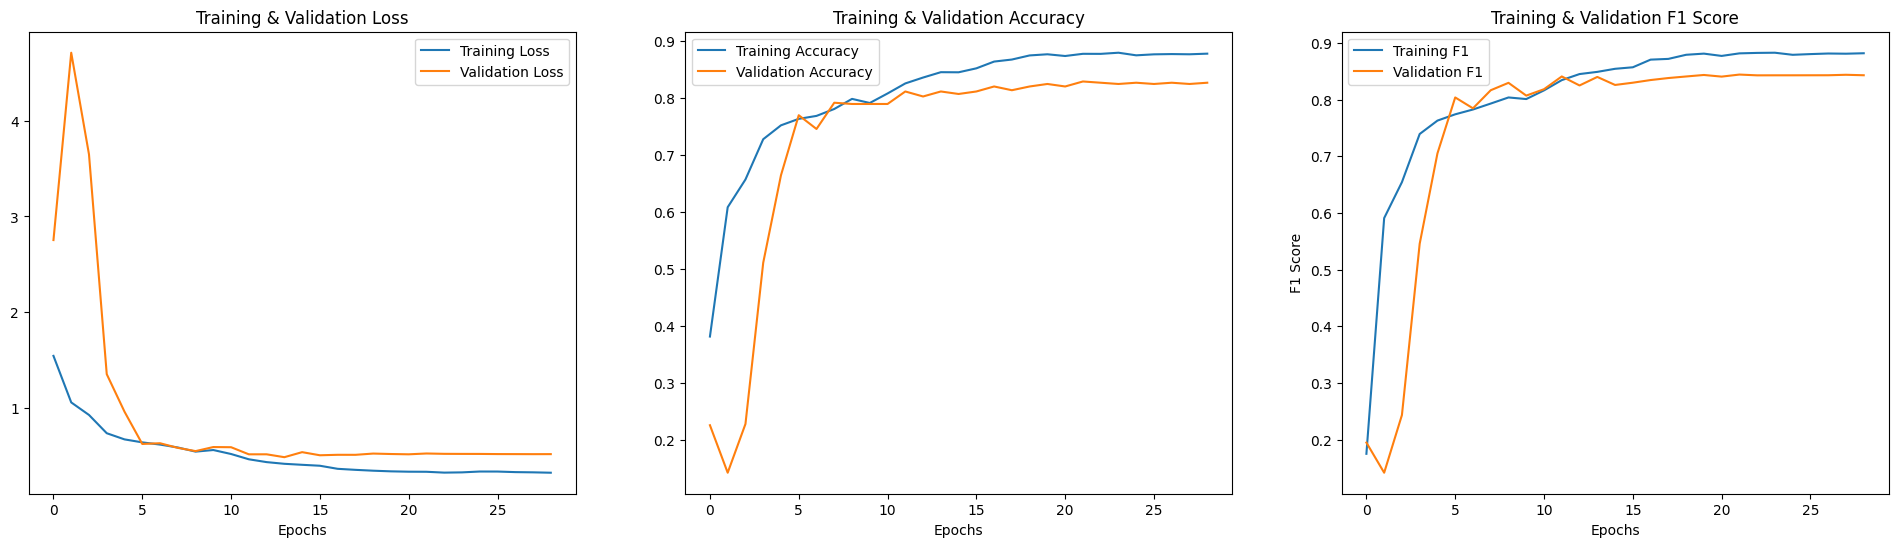

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


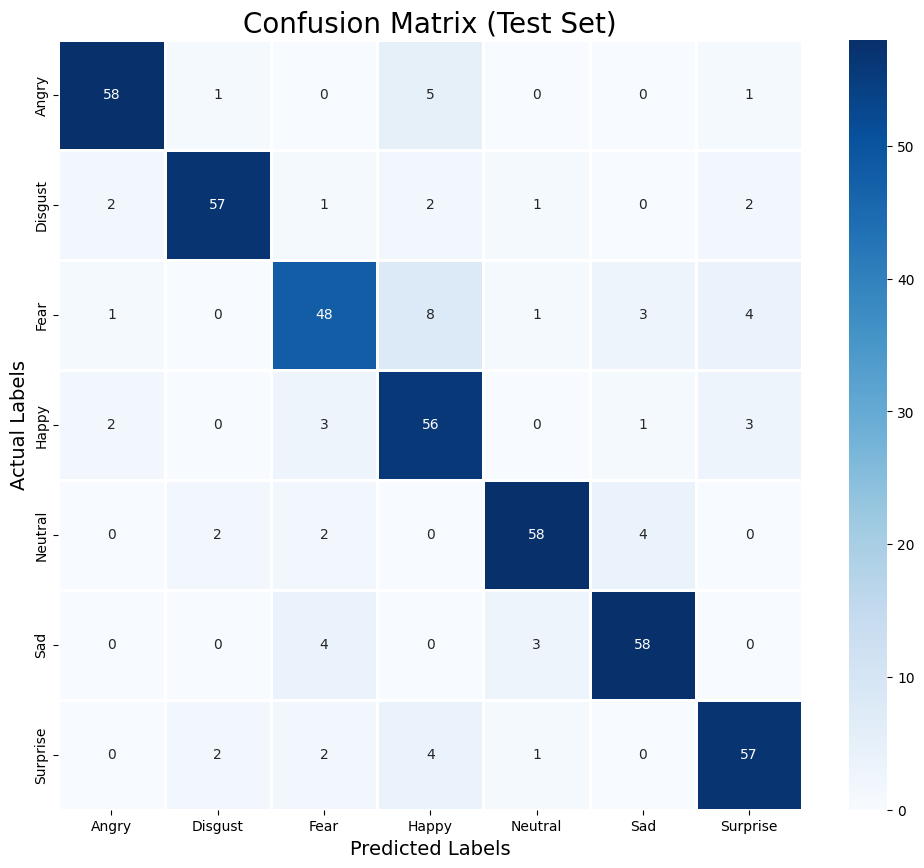

              precision    recall  f1-score   support

       Angry       0.92      0.89      0.91        65
     Disgust       0.92      0.88      0.90        65
        Fear       0.80      0.74      0.77        65
       Happy       0.75      0.86      0.80        65
     Neutral       0.91      0.88      0.89        66
         Sad       0.88      0.89      0.89        65
    Surprise       0.85      0.86      0.86        66

    accuracy                           0.86       457
   macro avg       0.86      0.86      0.86       457
weighted avg       0.86      0.86      0.86       457



In [16]:
print("Accuracy on Test Data: " , model.evaluate(x_test_cnn, y_test_encoded)[1]*100 , "%")

# Plot Curves
epochs = [i for i in range(len(history.history['accuracy']))]
fig , ax = plt.subplots(1,3)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
train_f1 = history.history['f1_metric']
val_f1 = history.history['val_f1_metric']

fig.set_size_inches(24,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , val_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , val_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

if 'f1_metric' in history.history:
    ax[2].plot(epochs, train_f1, label='Training F1')
    ax[2].plot(epochs, val_f1, label='Validation F1')
    ax[2].set_title('Training & Validation F1 Score')
    ax[2].legend()
    ax[2].set_xlabel("Epochs")
    ax[2].set_ylabel("F1 Score")
else:
    print("Not found f1_metric!")
plt.show()

# Confusion Matrix
pred_test = model.predict(x_test_cnn)
y_pred = encoder.inverse_transform(pred_test)
y_true = encoder.inverse_transform(y_test_encoded)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_[0]] , columns = [i for i in encoder.categories_[0]])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix (Test Set)', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

print(classification_report(y_true, y_pred))

In [109]:
import pickle
import os


save_dir = '/kaggle/working/saved_models_clstm/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

with open(os.path.join(save_dir, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)
    print("Saved scaler.pkl")

with open(os.path.join(save_dir, 'encoder.pkl'), 'wb') as f:
    pickle.dump(encoder, f)
    print("Saved encoder.pkl")

Saved scaler.pkl
Saved encoder.pkl


In [126]:
import os
import numpy as np
import librosa
import pickle
from tensorflow.keras.models import load_model

# Cấu hình đường dẫn (Đảm bảo đúng đường dẫn file đã lưu)
MODEL_PATH = '/kaggle/working/best_model_clstm.keras'
SCALER_PATH = '/kaggle/working/saved_models_clstm/scaler.pkl' 
ENCODER_PATH = '/kaggle/working/saved_models_clstm/encoder.pkl'

# --- Feature Extraction (Logic Mới - 162 features) ---
def extract_features(data, sample_rate):
    # Hàm này phải GIỐNG HỆT hàm dùng lúc train
    result = np.array([])
    
    # 1. ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr)) 

    # 2. Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) 

    # 3. MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) 

    # 4. RMS
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) 

    # 5. MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) 
    
    return result

def get_predict_feat(path):
    # Load audio
    d, s_rate = librosa.load(path, duration=2.5, offset=0.6)
    res = extract_features(d, s_rate)
    result = np.array(res)

    result = result.reshape(1, -1) 
    
    i_result = loaded_scaler.transform(result)

    final_result = np.expand_dims(i_result, axis=2)
    
    return final_result

def prediction(path):
    if not os.path.exists(path):
        print(f"File not found: {path}")
        return

    try:
        res = get_predict_feat(path)
        predictions = loaded_model.predict(res, verbose=0)
        y_pred = loaded_encoder.inverse_transform(predictions)
        print(f"File: {os.path.basename(path)}")
        print(f"Prediction: {y_pred[0][0]} (Confidence: {np.max(predictions)*100:.2f}%)")
        print("-" * 30)
    except Exception as e:
        print(f"Error predicting {path}: {e}")

if __name__ == "__main__":
    try:
        print("Loading resources...")
        loaded_model = load_model(MODEL_PATH)
        with open(SCALER_PATH, 'rb') as f:
            loaded_scaler = pickle.load(f)
        with open(ENCODER_PATH, 'rb') as f:
            loaded_encoder = pickle.load(f)
        print("Resources loaded successfully.\n")
            
        test_file_1 = "/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-05-01-01-01-01.wav"
        test_file_2 = "/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-03-01-01-01-01.wav"
        
        prediction(test_file_1)
        prediction(test_file_2)

    except Exception as e:
        print(f"Initialization Error: {e}")

Loading resources...
Resources loaded successfully.

File: 03-01-05-01-01-01-01.wav
Prediction: Angry (Confidence: 94.53%)
------------------------------
File: 03-01-03-01-01-01-01.wav
Prediction: Happy (Confidence: 41.84%)
------------------------------


In [127]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-02-02-01.wav")

File: 03-01-07-01-02-02-01.wav
Prediction: Disgust (Confidence: 85.06%)
------------------------------
